# Informe - Analisis de demanda y precio de la Red Electrica de España

En el siguiente informe se detalla el estudio de datos provenientes de la Red Electrica de España, con intención de enlazar la información de demanda y de precios de la electricidad española mediante analisis no supervisado de la información, y finalmente usar los datos de demanda para predecir posibles valores de precio. El desarrollo se ha llevado a cabo usando la API de la propia red y del lenguaje Python, acompañado con distintas librerias de ciencia de datos

Los siguientes modulos son los necesarios para el analisis de los datos. Los pertenecientes al modulo "modules" son hechos por mi mismo:

 ~ download: Contiene el metodo "download()", que al ejecutarlo con los argumentos correspondentes a el idioma, categoria, widget respectivamente, realiza una peticion GET a la REE con esos elementos dando origen a la siguiente direccion:
 http://apidatos.ree.es/{lang}/datos/{category}/{widget}?[query]
Al hacer la peticion, se guardaran JSON con la informacion descargada en la direccion ./datasets/{category}/ de donde ejecutes el fichero .py . Estos JSON serán los propios para todos los meses desde el 1 de enero de 2017 al 31 de diciembre de 2019.

Antes de bajar los datos, hace un check de si tiene un fichero con el nombre con el que guarda
 '''
 Ejemplo
 '''
 download("es","mercados","precios-mercados-tiempo-real")

 ~ preprocessing: contiene los metodos cleanup y back_sequence:
             
     cleanup: Este metodo lee una ruta hacia un JSON para procesarlo del siguiente modo:
      * Extrae la etiqueta "values" del JSON
      * De ellos, extrae los valores y la fecha asociada
      * Procesa todos los valores referentes a cada fecha, creando finalmente un DataFrame de Pandas con una fila por dia y 24 columnas referentes a cada hora. Para dias con mas horas, extrapola la información haciendo la media entre cada hora y si siguiente, mientras que para obtener la información de una hora más, hago uso de la interpolación de Splines, ya que se ajusta bastante bien a datos temporales.
      * Al metodo, a parte de la ruta al JSON, hay que darle el separador de tiempo que usan los datos, por ahora horas o minutos (argumentos "hour" o "minutes")
  
      back_sequence: Este metodo toma como argumentos un objeto iterable y un entero (lookback) , y devuelve una numpy array de forma que el i-esimo elemento son los elementos del objeto iterable desde el i al i+lookback

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale, MinMaxScaler
from modules.download import download
from modules.preprocessing import cleanup, back_sequence
from collections import defaultdict,Counter
from tensorflow.keras.layers import Dense, GRU, Conv1D, MaxPooling1D, LSTM, Input, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential

file = "datasets/{category}/datos-{category}-{m}-{y}.json"

In [2]:
# Descarga de los datos en uso
download("es", "demanda", "demanda-tiempo-real")
download("es", "mercados", "precios-mercados-tiempo-real")

### Analisis de los datos

A modo de muestra, tenemos aqui una muestra de la información de 2017, concretamente de todo el mes de enero, desglosado en 24 columnas referentes a cada hora y filas para cada dia del mes.


In [3]:
demanda_enero_2017 = cleanup(file.format(category="demanda", m=1, y=2017),'minute')
demanda_enero_2017

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,24487.5,23541.5,22016.5,20682.5,19623.5,19232.0,19330.0,19683.5,19598.5,20106.0,...,24866.0,23487.0,22939.0,23278.5,26305.0,27567.5,28547.0,29154.5,28758.0,26617.0
1,24028.5,21763.5,20447.5,19836.0,19760.0,20333.0,22581.5,25691.0,28448.0,30673.5,...,32798.0,31886.5,31513.0,32038.5,34089.5,34621.5,34971.0,34830.5,32998.0,30021.5
2,27383.5,24987.5,23322.0,22800.0,22499.0,23124.0,25337.0,29008.0,32195.0,34750.0,...,34445.5,33483.5,33113.5,33523.5,35606.5,35964.0,36224.0,35821.5,33862.0,30721.0
3,27865.0,25546.5,24056.0,23343.0,23171.5,23574.0,25670.0,29359.0,32296.5,34524.5,...,33626.0,32747.5,32490.0,32836.5,34732.5,35296.0,35288.5,35277.5,33726.0,30777.5
4,28248.5,25556.0,24204.5,23449.0,23193.0,23468.5,25186.0,28646.5,31191.0,33579.0,...,32214.5,30861.0,30522.0,30453.5,31902.0,31874.0,31758.0,31845.0,30511.5,28667.5
5,26735.0,24299.0,22495.0,21487.5,21185.5,21106.0,21294.5,22346.0,22725.5,24510.0,...,26524.0,24944.0,24272.0,24396.0,26989.5,28385.0,29531.5,30103.5,29902.5,28042.5
6,26146.0,24040.5,22347.0,21575.0,21389.0,21527.0,22485.0,23939.0,25348.0,27760.0,...,30072.0,28948.0,28290.0,28361.0,31023.5,32471.0,33069.5,33230.0,31869.0,29558.5
7,27015.5,24634.5,22880.0,21967.0,21565.5,21580.5,22043.0,22760.0,23495.5,25191.5,...,29151.5,28111.5,27384.0,27404.5,30406.5,32225.5,33736.0,33971.0,32408.5,29377.5
8,26432.0,24204.0,23064.5,22622.5,22637.5,23078.5,25873.0,31372.0,35794.0,36886.0,...,35167.5,34642.0,34390.5,34805.5,37100.0,38331.0,38572.5,38372.0,35355.5,31644.5
9,29103.0,26534.5,25023.0,24445.0,24229.5,24797.5,27527.0,32500.5,36438.0,37333.5,...,36418.0,35683.0,35581.5,36023.5,37800.0,38794.5,38941.0,38291.0,35248.5,31654.0


Para ver un poco como fluctuan los datos, antes que fijarse en cada número de la tabla, es conveniente tomar algun criterio con el que sacar conclusiones de como estan funcionando los datos

Aqui grafico, tambien referente a enero de 2017, los valores de demanda medio por hora y medio por dia. Se puede ver claramente que tanto la hora del dia (las conocidas como horas pico) como los dias del mes, son relevantes en las tendencias

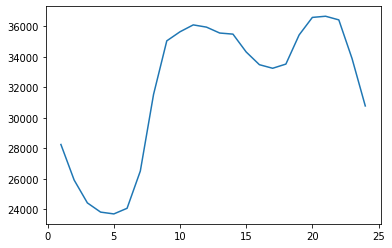

In [4]:
medias_hora = [demanda_enero_2017[i].median() for i in range(24)]
grafica_medias_hora = plt.plot(list(range(1,25)), medias_hora)
plt.show(grafica_medias_hora)

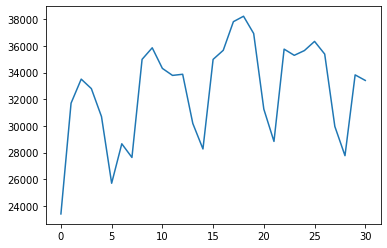

In [5]:
medias_dia = [ row.median() for _, row in demanda_enero_2017.iterrows()]
plt.plot(list(range(31)), medias_dia)

Almacenamos en las variables "datos_demanda" y "datos_precio" los valores extraidos de todos los JSON referentes a estas categorias tienen unas dimensiones de 1095 x 24. Además, tambien guardo las fechas, que mas tarde nos ayudan a relacionar cada fila del DataFrame con la fecha a la que pertenece, sin incluirlo en las variables para usarlo unicamente en procesarlo

In [6]:
datos_demanda_raw = pd.DataFrame()
datos_precio_raw = pd.DataFrame()
dates = []

for year in (2017,2018,2019):
    for m in range(1,13):
        values = cleanup(file.format(category="mercados", m=m, y=year), 'hour')
        datos_precio_raw = datos_precio_raw.append(values)
        values = cleanup(file.format(category="demanda", m=m, y=year), 'minute')
        datos_demanda_raw = datos_demanda_raw.append(values)
        for d in range(1,len(values)+1):
            dates.append(datetime(year, m, d).strftime("%A, %d - %b - %y"))
dates = pd.Series(dates)

In [7]:
datos_demanda_raw

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,24487.5,23541.5,22016.5,20682.5,19623.5,19232.0,19330.0,19683.5,19598.5,20106.0,...,24866.0,23487.0,22939.0,23278.5,26305.0,27567.5,28547.0,29154.5,28758.0,26617.0
1,24028.5,21763.5,20447.5,19836.0,19760.0,20333.0,22581.5,25691.0,28448.0,30673.5,...,32798.0,31886.5,31513.0,32038.5,34089.5,34621.5,34971.0,34830.5,32998.0,30021.5
2,27383.5,24987.5,23322.0,22800.0,22499.0,23124.0,25337.0,29008.0,32195.0,34750.0,...,34445.5,33483.5,33113.5,33523.5,35606.5,35964.0,36224.0,35821.5,33862.0,30721.0
3,27865.0,25546.5,24056.0,23343.0,23171.5,23574.0,25670.0,29359.0,32296.5,34524.5,...,33626.0,32747.5,32490.0,32836.5,34732.5,35296.0,35288.5,35277.5,33726.0,30777.5
4,28248.5,25556.0,24204.5,23449.0,23193.0,23468.5,25186.0,28646.5,31191.0,33579.0,...,32214.5,30861.0,30522.0,30453.5,31902.0,31874.0,31758.0,31845.0,30511.5,28667.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,23077.5,21040.0,20011.0,19548.5,19394.5,19916.0,21859.5,24703.0,27025.0,29078.0,...,29195.5,27947.5,27652.5,27674.0,29719.5,30156.0,30327.5,30189.5,28366.0,26094.5
27,24237.5,22108.5,20793.5,20112.5,19702.0,19795.5,20666.0,22089.5,23681.0,25921.0,...,27531.0,26317.5,25714.0,25634.5,27845.5,28681.0,29304.5,29348.0,27949.0,25886.0
28,23885.0,21865.5,20564.0,19642.0,19262.0,19354.0,19755.5,20523.0,21463.0,23162.5,...,26206.0,24906.0,24330.0,24384.0,26803.5,27865.0,28689.5,29036.5,28017.5,25888.5
29,23414.0,21346.5,20256.0,19611.0,19623.0,20005.0,21788.0,24744.0,27495.5,29987.0,...,29865.0,28792.5,28415.0,28551.0,30474.0,31046.0,31258.0,31281.5,29514.5,26940.5


In [8]:
datos_precio_raw

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,132.63,135.59,129.90,125.38,123.84,122.72,122.60,122.55,119.35,116.78,...,120.95,120.15,120.83,127.76,134.42,135.79,137.63,132.23,129.79,121.53
1,128.92,123.87,120.91,119.43,118.55,120.34,124.24,130.16,133.22,131.35,...,128.04,127.02,127.31,136.53,140.28,141.97,138.66,134.19,130.78,129.82
2,126.81,124.39,120.24,115.85,116.10,120.33,129.89,141.30,139.10,139.06,...,138.93,138.66,138.89,139.75,141.50,142.64,145.28,142.51,142.26,139.56
3,136.96,129.05,126.49,124.19,122.97,124.63,135.63,145.85,143.32,144.58,...,137.84,135.87,136.71,141.10,144.29,145.16,145.13,140.49,137.25,134.17
4,123.83,121.60,122.75,120.03,113.54,115.70,125.36,136.40,137.20,138.79,...,139.61,139.33,137.68,141.74,142.33,143.88,142.67,142.33,138.63,142.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,90.86,88.50,83.36,82.35,78.64,82.90,87.77,93.20,97.07,99.13,...,94.15,91.62,95.92,101.56,107.16,106.26,101.26,98.59,96.92,95.65
27,93.63,93.48,88.48,85.65,83.10,84.19,84.21,86.01,88.76,97.19,...,90.65,86.48,92.92,100.95,105.82,105.30,101.23,96.63,97.22,91.98
28,94.88,92.36,90.90,86.37,84.35,85.05,86.04,88.51,90.04,93.09,...,91.40,92.45,95.46,103.83,105.84,105.72,101.66,103.12,101.81,97.65
29,96.99,88.24,85.59,85.14,84.54,85.05,94.41,104.09,105.27,105.25,...,94.65,94.60,97.94,106.06,109.18,110.88,110.83,109.95,105.32,103.42


Para elegir el modelo correcto, hacemos uso de graficas que informen sobre la precisión del modelo y su puntuacion Sillhouette. Estos darán el mejor modelo cuando, en el caso de la precisión, la linea sea aplane, siendo el elegido aquel que de comienzo a la tendencia, mientras que la puntuación Sillhouette apunta al mejor cuando este es el segundo máximo. En el caso de la demanda, podemos ver que el mejor seria el que posee 8 clusters, mientras que para los datos de precios, seria con 10 clusters.

In [9]:
# De forma general, normalizar los datos ayuda mucho para mantener los numeros a una baja escala y reducir errores
# Esto lo llevamos a cabo con scale()
datos_demanda = scale(datos_demanda_raw)
n_clusters = 20
models = [KMeans(n_clusters=i) for i in range(2,n_clusters+1)]
scores = [model.fit(datos_demanda).score(datos_demanda) for model in models]
sillhouette_scores = [silhouette_score(datos_demanda, model.predict(datos_demanda)) for model in models]

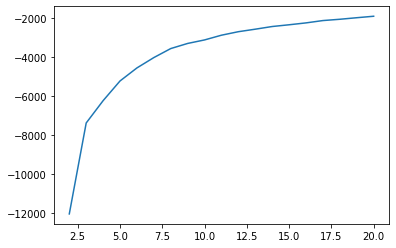

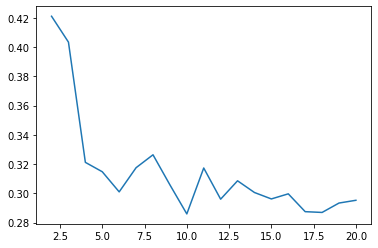

In [10]:
plt.show(plt.plot(range(2,n_clusters+1), scores))
plt.show(plt.plot(range(2,n_clusters+1), sillhouette_scores))

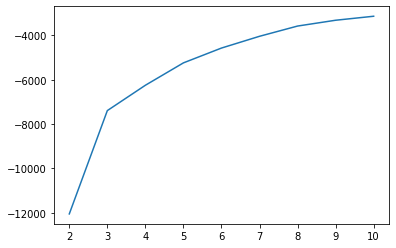

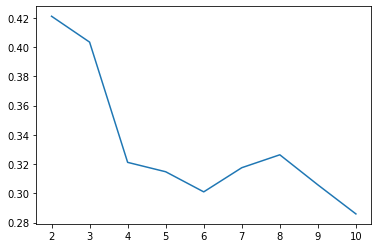

In [11]:
# Miramos un poco más cerca, por donde intuimos que estan los valores que queremos...
plt.show(plt.plot(range(2,11), scores[:9]))
plt.show(plt.plot(range(2,11), sillhouette_scores[:9]))

In [12]:
#Elegido el modelo, lo almacenamos en una variable clustering_demanda donde relacionamos fecha con cluster
model_demanda = models[6]
clustering_demanda = []
for c,d in zip(model_demanda.predict(datos_demanda), dates):
    clustering_demanda.append((d,c))

In [13]:
clustering_demanda[500:510]

[('Wednesday, 16 - May - 18', 0),
 ('Thursday, 17 - May - 18', 0),
 ('Friday, 18 - May - 18', 0),
 ('Saturday, 19 - May - 18', 1),
 ('Sunday, 20 - May - 18', 6),
 ('Monday, 21 - May - 18', 5),
 ('Tuesday, 22 - May - 18', 0),
 ('Wednesday, 23 - May - 18', 0),
 ('Thursday, 24 - May - 18', 0),
 ('Friday, 25 - May - 18', 0)]

In [14]:
#¿Que dias forman parte del cluster 1?
list(filter(lambda x: x[1] == 1, clustering_demanda))

[('Friday, 06 - Jan - 17', 1),
 ('Sunday, 05 - Feb - 17', 1),
 ('Sunday, 12 - Feb - 17', 1),
 ('Sunday, 19 - Feb - 17', 1),
 ('Sunday, 26 - Feb - 17', 1),
 ('Sunday, 05 - Mar - 17', 1),
 ('Saturday, 11 - Mar - 17', 1),
 ('Saturday, 18 - Mar - 17', 1),
 ('Sunday, 26 - Mar - 17', 1),
 ('Saturday, 01 - Apr - 17', 1),
 ('Saturday, 08 - Apr - 17', 1),
 ('Saturday, 22 - Apr - 17', 1),
 ('Saturday, 29 - Apr - 17', 1),
 ('Saturday, 06 - May - 17', 1),
 ('Saturday, 13 - May - 17', 1),
 ('Saturday, 20 - May - 17', 1),
 ('Saturday, 27 - May - 17', 1),
 ('Saturday, 03 - Jun - 17', 1),
 ('Sunday, 11 - Jun - 17', 1),
 ('Saturday, 01 - Jul - 17', 1),
 ('Sunday, 09 - Jul - 17', 1),
 ('Sunday, 23 - Jul - 17', 1),
 ('Saturday, 12 - Aug - 17', 1),
 ('Tuesday, 15 - Aug - 17', 1),
 ('Sunday, 20 - Aug - 17', 1),
 ('Sunday, 27 - Aug - 17', 1),
 ('Saturday, 02 - Sep - 17', 1),
 ('Sunday, 03 - Sep - 17', 1),
 ('Saturday, 09 - Sep - 17', 1),
 ('Saturday, 16 - Sep - 17', 1),
 ('Saturday, 23 - Sep - 17', 1),
 ('S

In [15]:
#Procedemos de la misma manera que con la demanda
datos_precio = scale(datos_precio_raw)
n_clusters = 20
models = [KMeans(n_clusters=i) for i in range(2,n_clusters+1)]
scores = [model.fit(datos_precio).score(datos_precio) for model in models]
sillhouette_scores = [silhouette_score(datos_precio, model.predict(datos_precio)) for model in models]

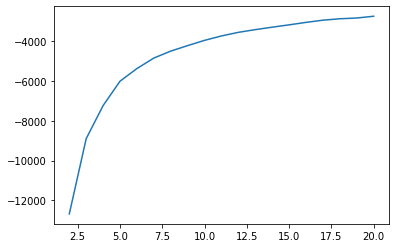

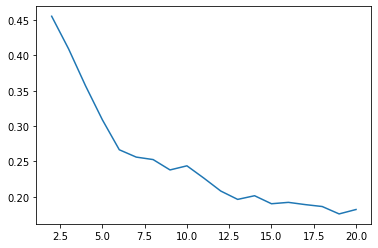

In [16]:
plt.show(plt.plot(range(2,n_clusters+1), scores))
plt.show(plt.plot(range(2,n_clusters+1), sillhouette_scores))

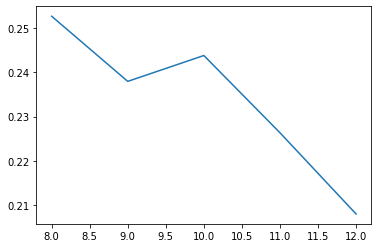

In [17]:
plt.show(plt.plot(range(8,13), sillhouette_scores[6:11]))

In [18]:
model_precio = models[8]
clustering_precio = []
for c,d in zip(model_precio.predict(datos_precio), dates):
    clustering_precio.append((d,c))

In [19]:
clustering = defaultdict(int)
for i in range(len(dates)):
    clustering[(clustering_demanda[i][1], clustering_precio[i][1])] +=1

Para llevar a cabo un analisis individual de los datos, tomo ambos grupos de clustering y los divido por estaciones, y dentro de las mismas, por dias lectivos y dias festivos nacionales.

In [20]:
festivos = {2017:[datetime(2017,1,1),
                  datetime(2017,1,6),
                  datetime(2017,2,2),
                  datetime(2017,2,26),
                  datetime(2017,4,10),
                  datetime(2017,4,11),
                  datetime(2017,4,12),
                  datetime(2017,4,13),
                  datetime(2017,4,14),
                  datetime(2017,4,15),
                  datetime(2017,4,16),
                  datetime(2017,5,1),
                  datetime(2017,10,12),
                  datetime(2017,11,1),
                  datetime(2017,12,6),
                  datetime(2017,12,7),
                  datetime(2017,12,8),
                  datetime(2017,12,24),
                  datetime(2017,12,25),
                  datetime(2017,12,31)],
            2018:[datetime(2018,1,1),
                  datetime(2018,1,6),
                  datetime(2018,2,2),
                  datetime(2018,2,11),
                  datetime(2018,3,28),
                  datetime(2018,3,27),
                  datetime(2018,3,28),
                  datetime(2018,3,29),
                  datetime(2018,3,30),
                  datetime(2018,3,31),
                  datetime(2018,4,1),
                  datetime(2018,5,1),
                  datetime(2018,10,12),
                  datetime(2018,11,1),
                  datetime(2018,12,6),
                  datetime(2018,12,7),
                  datetime(2018,12,8),
                  datetime(2018,12,24),
                  datetime(2018,12,25),
                  datetime(2018,12,31)],
            2019:[datetime(2019,1,1),
                  datetime(2019,1,6),
                  datetime(2019,2,2),
                  datetime(2019,2,11),
                  datetime(2019,3,3),
                  datetime(2019,4,15),
                  datetime(2019,4,16),
                  datetime(2019,4,17),
                  datetime(2019,4,18),
                  datetime(2019,3,19),
                  datetime(2019,4,20),
                  datetime(2019,4,21),
                  datetime(2019,5,1),
                  datetime(2019,10,12),
                  datetime(2019,11,1),
                  datetime(2019,12,6),
                  datetime(2019,12,7),
                  datetime(2019,12,8),
                  datetime(2019,12,24),
                  datetime(2019,12,25),
                  datetime(2019,12,31)]}

In [21]:
# Etiqueto los datos de demanda
clustering_etiquetado_demanda = defaultdict(list)
for cluster in clustering_demanda:
    date = datetime.strptime(cluster[0], "%A, %d - %b - %y")
    year = date.year
    if date < datetime(year, 3, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["invierno festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["invierno lectivo"].append(cluster[1])
    elif date < datetime(year, 6, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["primavera festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["primavera lectivo"].append(cluster[1])
    elif date < datetime(year, 9, 22):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["verano festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["verano lectivo"].append(cluster[1])
    else:
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_demanda["otoño festivo"].append(cluster[1])
        else:
            clustering_etiquetado_demanda["otoño lectivo"].append(cluster[1])

for temporada in clustering_etiquetado_demanda:
    clustering_etiquetado_demanda[temporada] = Counter(clustering_etiquetado_demanda[temporada])
clustering_etiquetado_demanda

defaultdict(list,
            {'invierno festivo': Counter({6: 5, 5: 1, 3: 33, 4: 6, 1: 22}),
             'invierno lectivo': Counter({5: 8,
                      7: 73,
                      0: 22,
                      1: 1,
                      2: 61,
                      6: 2}),
             'primavera lectivo': Counter({5: 37,
                      0: 123,
                      7: 13,
                      6: 9,
                      4: 3,
                      2: 9,
                      1: 4}),
             'primavera festivo': Counter({3: 8, 1: 35, 6: 34, 4: 1}),
             'verano lectivo': Counter({2: 23,
                      4: 102,
                      0: 47,
                      7: 20,
                      5: 8,
                      1: 3}),
             'verano festivo': Counter({3: 32, 1: 35, 6: 7, 4: 5}),
             'otoño lectivo': Counter({0: 68,
                      5: 41,
                      1: 7,
                      7: 72,
                      2: 1

In [22]:
clustering_etiquetado_precio = defaultdict(list)
for cluster in clustering_precio:
    date = datetime.strptime(cluster[0], "%A, %d - %b - %y")
    year = date.year
    if date < datetime(year, 3, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_precio["invierno festivo"].append(cluster[1])
        else:
            clustering_etiquetado_precio["invierno lectivo"].append(cluster[1])
    elif date < datetime(year, 6, 20):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_precio["primavera festivo"].append(cluster[1])
        else:
            clustering_etiquetado_precio["primavera lectivo"].append(cluster[1])
    elif date < datetime(year, 9, 22):
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_precio["verano festivo"].append(cluster[1])
        else:
            clustering_etiquetado_precio["verano lectivo"].append(cluster[1])
    else:
        if cluster in festivos[year] or date.weekday() in (5,6):
            clustering_etiquetado_precio["otoño festivo"].append(cluster[1])
        else:
            clustering_etiquetado_precio["otoño lectivo"].append(cluster[1])
for temporada in clustering_etiquetado_precio:
    clustering_etiquetado_precio[temporada] = Counter(clustering_etiquetado_precio[temporada])
clustering_etiquetado_precio

defaultdict(list,
            {'invierno festivo': Counter({5: 11,
                      3: 7,
                      9: 2,
                      4: 10,
                      0: 4,
                      1: 14,
                      2: 10,
                      7: 5,
                      8: 3,
                      6: 1}),
             'invierno lectivo': Counter({5: 33,
                      3: 23,
                      9: 8,
                      2: 49,
                      4: 17,
                      7: 5,
                      1: 23,
                      0: 1,
                      6: 1,
                      8: 7}),
             'primavera lectivo': Counter({1: 62,
                      4: 73,
                      7: 34,
                      0: 5,
                      6: 1,
                      5: 18,
                      2: 5}),
             'primavera festivo': Counter({7: 15,
                      0: 8,
                      1: 22,
                      4: 26,
          

Con todos estos datos puestos en comun, podemos formular una serie de tablas valores y frecuencias que nos digan si los clusters obtenidos tienen relevancia o no con respecto a las etiquetas elegidas.

### Analisis de etiquetado - demanda
Los siguientes datos nos dan informacion sobre la demanda

<img src="./data/demanda - 1.png">
Aqui tenemos la distribución de valores en funcion de cada cluster y etiqueta. Para facilitar verlo, calculamos el porcentaje de elementos del mismo cluster en cada etiqueta
<img src="./data/demanda - 2.png">
Aqui podemos ver definitivamente que existe una cierta correlación entre clusters y etiquetas, viendo como clusters como el 0 o el 2 descatalogan totalmente dias lectivos, mientras que otros como el 6, hacen el efecto contrario. De forma analoga, se puede calcular que porcentaje de etiqueta se encuentra en cada cluster
<img src="./data/demanda - 3.png">
Aqui se ve como algunos clusters etiquetan por si mismos o con una cierta probabilidad, como el cluster 2 con los inviernos y veranos lectivos, que clasifica bien periodos lectivos, en concreto con alto porcentaje si se trata de invierno y en algo menor al verano. Tambien podemos ver que la mayor parte del año, como cabe apreciar en las estadisticas de distribucion de abajo, se aprecia que efectivamente, la mayor parte del año se trata de periodo lectivo.
<img src="./data/demanda - 4.png">
Finalmente, estos valores serian los esperados para una asignacion arbitraria de etiquetas. Como podemos ver, los obtenidos anteriormente distan bastantes de estos, concluyendo en que ha sido una buena clasificación. Además, una prueba Chi Cuadrado entre estos valores y la distribucion de porcentajes dan lugar a 0, dando a entender que la correlacion es muy buena

### Analisis de etiquetado - precio

Del mismo modo que hemos analizado el etiquetado anterior, podemos hacerlo con el precio
<img src="./data/precio - 1.png">
<img src="./data/precio - 2.png">
Aunque no tan acentuada como con la demanda, tambien vemos ciertas tendencias en los porcentajes de precio. Por ejemplo, el cluster 8 destaca al verano
<img src="./data/precio - 3.png">
Aqui tambien podemos ver información sobre el etiquetado, como que el cluster 3 ocupa la mayoria del tiempo lectivo mas frio (otoño e invierno)
<img src="./data/precio - 4.png">
La distribucion esperada si fuera una etiquetacion aleatoria da a ver que, aunque no de una forma tan rotunda, tambien separan los clusters a los distintos grupos. Hay que tener en cuenta que la distribucion de dias entre lectivos y no lectivos es similar en cada estacion, y los dias a su vez tambien, de modo que ver diferencias en los porcentajes equivale a un trabajo de filtrado que está presente

### Analisis de correlación de variables

Para finalizar, puede ser interesante estudiar la relación (más allá de la lógica) entre la demanda y el precio. 
<img src="./data/clusters - 1.png">
<img src="./data/clusters - 2.png">
Como hemos visto antes, es visualmente mas intuitivo ver las relaciones en base a los porcentajes de ocupación. Aqui vemos como algunos clusters tienen una alta tendencia por otros, como es el cluster 5 de precio (horizontal) se encuentra estrechamente relacionado con el cluster 3 de demanda (vertical), lo que se entiende como la existencia de muchos valores que, en un mismo dia, tomán ambos clusteres. 
<img src="./data/clusters - 3.png">
Como vemos aquí, ocurre algo parecido, habiendo una serie de tendencias no muy claras pero que permiten ver algunos encaminamientos
<img src="./data/clusters - 4.png">
Pero no es sino cuando comparamos con la distribución esperada de forma aleatoria (viendo como, aunque mas cercano que en los estudios anteriores, los valores siguen siendo distintos a los de la frecuencia obtenida) y hacemos el test chi cuadrado que vemos como la clasificacion de variables si tiene una correlación numerica a la clasificación dada.

## Predicción de precios en función de la demanda

Con los datos tomados ya limpiados anteriormente, procedemos a estimar un modelo de DL capaz de predecir los datos precios de septiembre de 2019. Para hacerlo, vamos a en primer lugar, identificar el problema.

Sabiendo los datos que tratamos, este problema trata de series temporales, por tanto es necesario escoger una ventana de tiempo para las predicciones. En lo personal he escogido 3 horas antes en demanda para predecir un precio, obteniendo unos resultados bastante aceptables. Lo que si suele traer problemas, al menos en cuestion de labor, son la forma de los datos. 

Por lo pronto, he extraido de los datos que ya tenemos todo lo que preceda a septiembre de 2019, ya que es lo que podria haber aprendido nuestro modelo para predecir esos precios. Lo hacemos eliminando los ultimos 4 meses (diciembre, noviembre, octubre y septiembre) de los datos, que ya estan por dias. Como la ventana de predicción va a ser de 3 horas, una vez aplanadas las array, se toman en cuenta mediante la indexación. La eleccion del indice de demanda es en relación a la transformación que se le hace tras pasar por el metodo back_sequence

In [23]:
x_train = datos_demanda[:-31-30-31-30].flatten()[:-1]
print(x_train.shape)
y_train= datos_precio_raw.to_numpy()[:-31-30-31-30].flatten()[3:]
print(y_train.shape)

(23351,)
(23349,)


Evidentemente, nuestros datos de test van a ser los propios datos de septiembre. Con una logica similar, sacamos los datos correspondientes a septiembre. Como nos interesan todos los valores de septiembres, en la indexacion dejamos los precios al completo

In [24]:
x_test = datos_demanda[[datetime(2019,8,31)<=datetime.strptime(x, "%A, %d - %b - %y")<=datetime(2019,9,30) for x in dates]].flatten()[21:-1]
y_test = datos_precio_raw[[datetime(2019,9,1)<=datetime.strptime(x, "%A, %d - %b - %y")<=datetime(2019,9,30) for x in dates]].to_numpy().flatten()

Debido a que manejamos datos de gran envergadura, es conveniente normalizarlos. Solo buscamos normalizar los datos que entraran en al red, debido a que como salida queremos datos de precio fiables

In [25]:
# Normalizacion

x_train = (x_train - min(x_train)) / (max(x_train) - min(x_train))
x_test = (x_test - min(x_test)) / (max(x_test) - min(x_test))

Debido a que necesitamos una estructura de arrays en las que le entre a la red batches de 3 datos de demanda para predecir un precio, reestructuramos con back_sequence y luego damos la forma necesaria para que cada valor vaya en un array distinto. Como podemos ver, tendremos la misma cantidad de entradas que de salidas, solo que en distinta distribución

In [26]:
x_train = back_sequence(x_train, 3).reshape(-1,3,1)
x_train.shape

(23349, 3, 1)

In [27]:
y_train.shape

(23349,)

A los datos de test tambien habria que darles la forma

In [28]:
x_test = back_sequence(x_test,3).reshape(-1,3,1)

Para la red neuronal, he elegido la API de Keras por estar familiarizado con ella, ya que puedo explorar las cosas que desconocia hasta ahora como las redes recurrentes.
He probado distintas combinaciones (redes convolucionales de 1 dimension, perceptrones multicapa, otras opciones recurrentes como GRU...) pero la mejor configuracion hasta el momento ha sido la siguiente. Como funciones de perdida y de optimizador he usado MAPE (mean absolute percentage error) y RMSprop, por ser conocidos y fiables para un problema de este estilo.

In [29]:
model = Sequential()
model.add(Input(shape=x_train.shape[-2:]))
model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

In [30]:
model.compile(loss='mape', optimizer='rmsprop')

Para el modelo dado, encontramos un minimo local cuando la funcion de perdida da valores alrededor del 99%, que supera sin muchas complicaciones (quizá reiniciar el modelo) y otro cuando llegamos al 8%, el cual es dificilemnte superable con la configuración dada. Con los valores fijados, el overfitting es seguro, llegando en unas entre 5 y 7 iteraciones a ese 8%. Debido a que converge muy rapido, seria necesario pararlo antes de que llegue, pero a más iteraciones, mas riesgo hay de converger. Por suerte, he tomado captura de algunos modelos en transición que dan prueba a que con un poco de paciencia se puede hallar un buen modelo:

<img src="./data/model - 3.png">
Modelo con underfitting
<img src="./data/model - 2.jpeg">
Modelo que mejor se ajusta
<img src="./data/model - 1.png">
Modelo con overfitting

In [31]:
history = model.fit(x_train, y_train, epochs = 10, batch_size=256, validation_data=(x_test, y_test))

Train on 23349 samples, validate on 720 samples
Epoch 1/10
23349/23349 [==============================] - 1s 60us/sample - loss: 99.1029 - val_loss: 96.9531
Epoch 2/10
23349/23349 [==============================] - 0s 12us/sample - loss: 92.4018 - val_loss: 82.8414
Epoch 3/10
23349/23349 [==============================] - 0s 9us/sample - loss: 74.1426 - val_loss: 54.9111
Epoch 4/10
23349/23349 [==============================] - 0s 10us/sample - loss: 44.6210 - val_loss: 14.2918
Epoch 5/10
23349/23349 [==============================] - 0s 9us/sample - loss: 12.7133 - val_loss: 16.6198
Epoch 6/10
23349/23349 [==============================] - 0s 9us/sample - loss: 8.4904 - val_loss: 14.7982
Epoch 7/10
23349/23349 [==============================] - 0s 11us/sample - loss: 8.4720 - val_loss: 14.3906
Epoch 8/10
23349/23349 [==============================] - 0s 10us/sample - loss: 8.4642 - val_loss: 15.0457
Epoch 9/10
23349/23349 [==============================] - 0s 9us/sample - loss: 8.4595

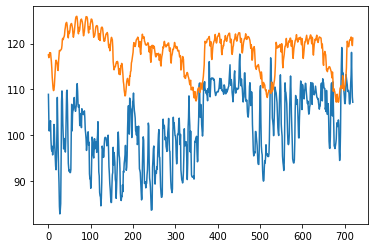

In [32]:
predicciones = model.predict(x_test)
real = plt.plot(list(range(len(predicciones))),y_test)
predicho = plt.plot(list(range(len(predicciones))), predicciones)
plt.show(real, predicho)

In [33]:
model.evaluate(x_test, y_test)

720/720 [==============================] - 0s 31us/sample - loss: 16.6583


16.65826244354248

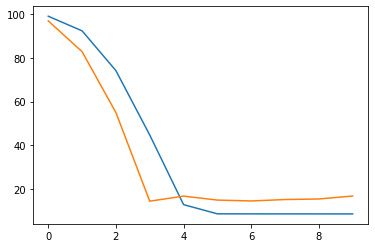

In [34]:
loss = plt.plot(range(len(history.history['loss'])),history.history['loss'])
val_loss = plt.plot(range(len(history.history['loss'])),history.history['val_loss'])
plt.show(loss, val_loss)

Aqui podemos ver a partir de que epoch sacariamos un mal rendimiento

¿Posibles soluciones a este problema?

Hacer el equivalente a un random forest, pero con varios modelos, por ejemplo. Otra solución pausible seria Cross-validation si queremos quitarle importancia a la longevidad de los datos en el aprendizaje del modelo, debido a que habria que sacrificar datos y desordenadorlos en el tiempo

### Conclusiones ¿Que he aprendido?

Este proyecto me ha dado a conocer partes del Machine Learning que no habia puesto en marcha jamás, como es el aprendizaje no supervisado y las redes neuronales recurrentes. Extrapolando al informe, he investigado sobre las distintas capas utiles para series temporales y modelos de regresión, asi como descubierto la utilidad en los mismos de redes convolucionales (las que hasta ahora pensaba que unicamente tenían utilidad en el Generative Learning o en Computer Vision), así como distintas formas estadisticas de analizar los datos, pasando por sacar información de una API de forma automatizada.